In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def visualize_output(csv_files):
    """
    Visualize list of Q8.8 CSV files as 3x3 grids with values.
    Args:
        csv_files (list): List of file paths.
                          Example: ['data/matlab.csv', 'data/verilog.csv']
    """
    n = len(csv_files)
    
    # Auto-adjust figure size based on file count
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))
    
    # Handle single file case (ensure axes is iterable)
    if n == 1:
        axes = [axes]

    for i, path in enumerate(csv_files):
        ax = axes[i]
        try:
            # 1. Load CSV & Flatten
            raw_data = pd.read_csv(path, header=None).values.flatten()
            
            # 2. Convert Q8.8 to Float (Divide by 256)
            float_data = raw_data / 256.0
            
            # 3. Extract Pixels (first 9) and Score (last one)
            pixels = float_data[:9].reshape(3, 3)
            score = float_data[9] if len(float_data) > 9 else 0
            
            # 4. Get filename for title
            filename = os.path.basename(path)
            
            # 5. Plot Heatmap
            # vmin=-1, vmax=1 ensures consistent grayscale for Tanh range
            sns.heatmap(pixels, annot=True, fmt=".2f", 
                        cmap='gray', vmin=-1, vmax=1, 
                        cbar=False, square=True, ax=ax,
                        annot_kws={"size": 12, "weight": "bold", "color": "red"}) 
            
            # Set Title & Remove Axes
            ax.set_title(f"{filename}\nScore: {score:.4f}", fontsize=14, fontweight='bold', pad=15)
            ax.axis('off')
            
        except Exception as e:
            # Handle reading errors
            ax.text(0.5, 0.5, f"Error Reading:\n{path}", 
                    ha='center', va='center', color='red', transform=ax.transAxes)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

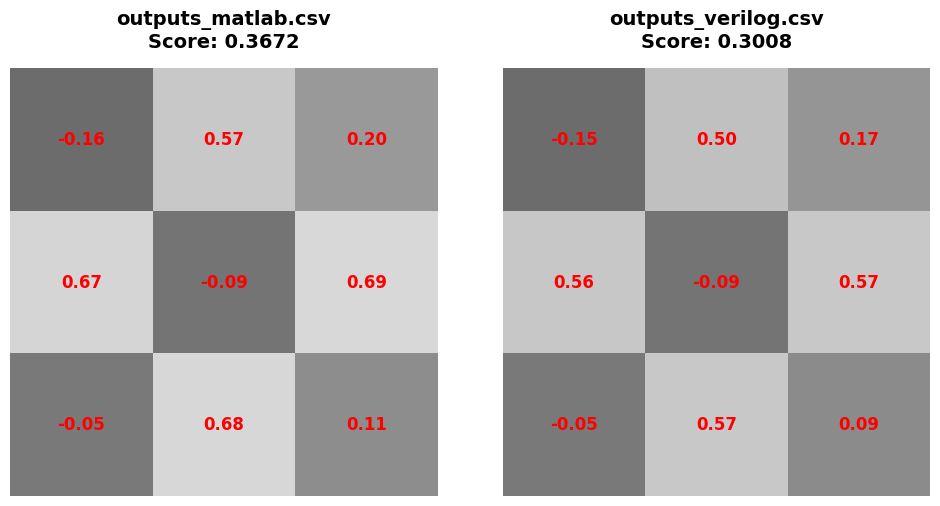

In [28]:
visualize_output([
    'data/outputs_matlab.csv', 
    'data/outputs_verilog.csv'
])

In [1]:
# generate noise inputs
import numpy as np
import pandas as pd

def generate_noise_csv(filename='data/inputs2.csv', num_samples=10):
    """
    Generate random noise (z1, z2) for GAN input.
    Format: Q8.8 Integer.
    """
    print(f"Generating {num_samples} samples...")
    
    # 1. Generate Random Noise (Normal Distribution)
    # Shape: (num_samples, 2) -> Column 0 is z1, Column 1 is z2
    noise_float = np.random.randn(num_samples, 2)
    
    # 2. Convert to Q8.8 Integer
    # Multiply by 256 and round to nearest integer
    noise_q88 = np.round(noise_float * 256).astype(int)
    
    # 3. Save to file
    # Uses space ' ' as separator because it's easier for Verilog to read
    df = pd.DataFrame(noise_q88, columns=['z1', 'z2'])
    df.to_csv(filename, index=False, header=False, sep=' ')
    
    print(f"Success! Saved to {filename}")
    print("First 5 samples:")
    print(df.head())

# Generate 12 samples for testing
generate_noise_csv('data/inputs2.csv', num_samples=12)

Generating 12 samples...
Success! Saved to data/inputs2.csv
First 5 samples:
    z1   z2
0 -406  127
1 -143 -342
2  -44 -114
3  160 -392
4  -13   -4


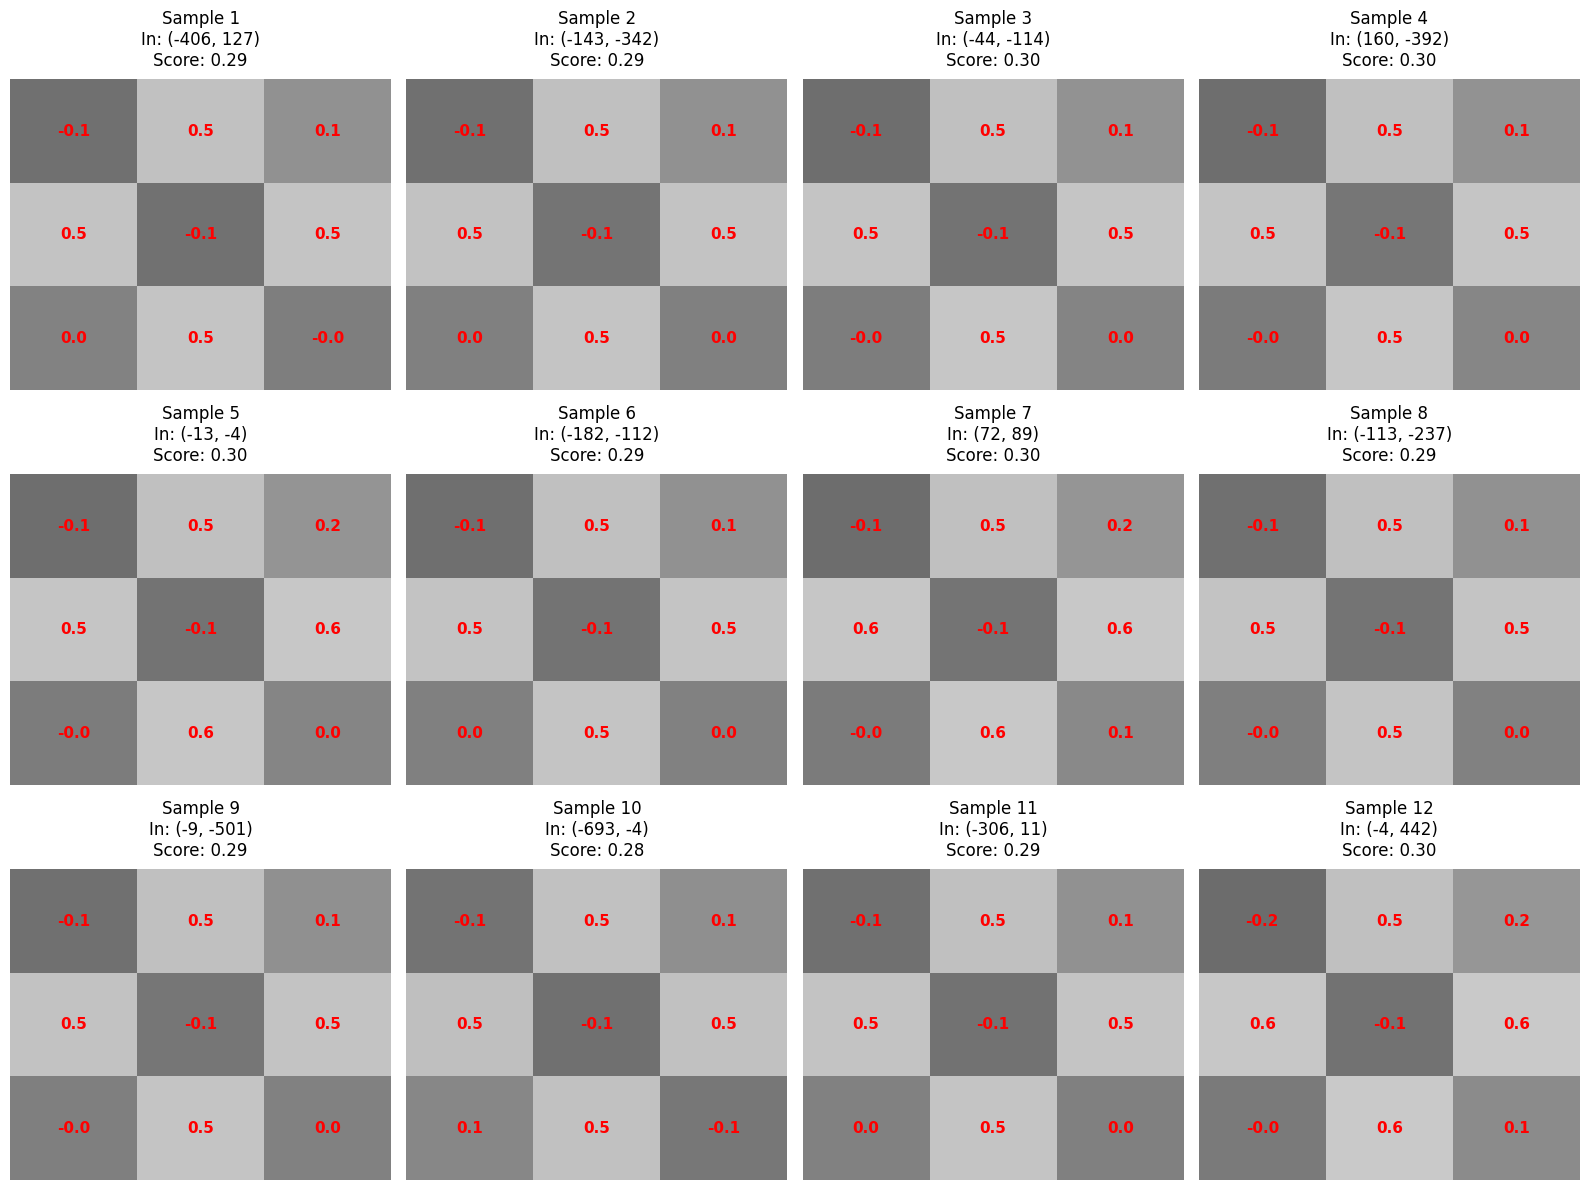

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_batch_with_inputs(input_path, output_path):
    """
    Visualizes batch results with input noise values.
    Args:
        input_path: Path to inputs2.csv (Space separated, z1 z2)
        output_path: Path to outputs2.csv (Comma separated, 9 pixels + 1 score)
    """
    try:
        # 1. Load Data
        # Inputs: Space separated
        df_in = pd.read_csv(input_path, sep=' ', header=None, names=['z1', 'z2'])
        
        # Outputs: Comma separated
        df_out = pd.read_csv(output_path, sep=',', header=None)
        
        num_samples = len(df_out)
        cols = 4  # Number of columns in grid
        rows = (num_samples // cols) + (1 if num_samples % cols > 0 else 0)
        
        # Adjust figure height based on rows
        fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
        axes = axes.flatten()
        
        for i in range(num_samples):
            # Get Input Data (z1, z2)
            z1 = df_in.iloc[i]['z1']
            z2 = df_in.iloc[i]['z2']
            
            # Get Output Data (Pixels + Score)
            row_raw = df_out.iloc[i].values
            float_data = row_raw / 256.0
            
            pixels = float_data[:9].reshape(3, 3)
            score = float_data[9]
            
            # Plot Heatmap
            sns.heatmap(pixels, annot=True, fmt=".1f", 
                        cmap='gray', vmin=-1, vmax=1, 
                        cbar=False, ax=axes[i],
                        annot_kws={"size": 11, "weight": "bold", "color": "red"})
            
            # Title with Inputs and Score
            title_text = (f"Sample {i+1}\n"
                          f"In: ({z1}, {z2})\n"
                          f"Score: {score:.2f}")
            
            axes[i].set_title(title_text, fontsize=12, pad=10)
            axes[i].axis('off')
            
        # Hide empty subplots
        for j in range(i+1, len(axes)):
            axes[j].axis('off')
            
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error: {e}")

# Usage
visualize_batch_with_inputs('data/inputs2.csv', 'data/outputs2.csv')